# Miguel Suarez


In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import product
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing Titanic Data
csv = '/content/drive/MyDrive/Colab Notebooks/Titanic-Dataset.csv'
data = pd.read_csv(csv)


In [ ]:
#Initial examination of data
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
#Turning data into dataframe and filling in missing age values with median age
df = pd.DataFrame(data)  #IT ALREADY WAS A DATAFRAME
median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)

# Filling null values in embarked with 'Not Known' (only 2 not known out of 891)
df['Embarked'] = df['Embarked'].fillna('Not Known')

#Excluding cabin from df for purposes of this analysis (less than 23% of records available ) and ticket as there are too many unique values for significant analysis.
# As well, excluding embark as the analysis we do would be based on those who are actually on board
df = df.drop(['Cabin'], axis=1)

df = df.drop(['Ticket'], axis=1)

#Examining that changes took place
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


#### One-Hot encoding the values to ensure I am able to analyze the data accordingly

In [ ]:
#One-hot encoding sex feature
df['Sex'] = df['Sex'].map({'male': 1, 'female': 2})

#Finding the unique values for embarked
print(f"The unique values are: {df['Embarked'].unique()}")

#One-hot encoding unique values for embarked (Port Of Embarkation)
df['Embarked'] = df['Embarked'].map({'S': 1, 'C': 2,'Q': 3, 'Not Known': 4})

#Examining that changes took place
df.info()

The unique values are: ['S' 'C' 'Q' 'Not Known']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 69.7+ KB


####I believe that passengers who paid higher fares for their tickets may have had better access to lifeboats or rescue priority. Grouping fares into bins can help clarify seeing this as a factor if necessary. Furthermore, it is most likely that children were a priority in assigning the life boats, and consequently, it would be important to see if this actually played out in real life.



In [ ]:
#Creating Bins for Price ranges between 0 (-1 is below 0) and 600. Labeling these as low, medium and high fare bins
bins = [-1, 75, 150, 600]
labels = ['Low', 'Medium', 'High']
df['FareBin'] = pd.cut(df['Fare'], bins, labels=labels)

#Creating boolean condition for whether a person is a child or not
df['IsChild'] = df['Age'] < 18

#Examining that changes took place
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    int64   
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Fare         891 non-null    float64 
 9   Embarked     891 non-null    int64   
 10  FareBin      891 non-null    category
 11  IsChild      891 non-null    bool    
dtypes: bool(1), category(1), float64(2), int64(7), object(1)
memory usage: 71.6+ KB


Text(4.944444444444445, 0.5, 'Count of People')

<Figure size 200x200 with 0 Axes>

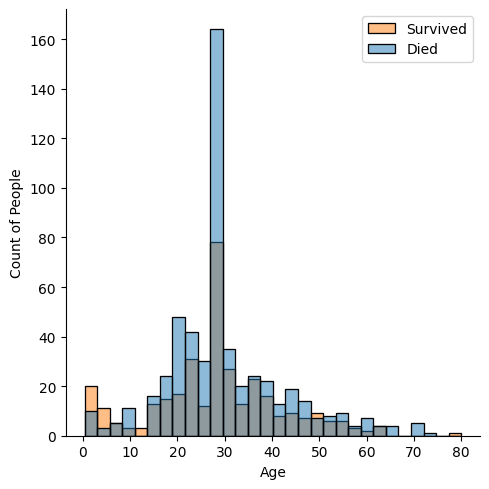

In [ ]:
# @title Understanding the distribution of age
plt.figure(figsize=(2, 2))
sns.displot(data=df, x='Age', hue ='Survived', legend=False)
plt.legend(labels=['Survived', 'Died'])
plt.ylabel('Count of People')

[Text(0, 0, 'Male'), Text(1, 0, 'Female')]

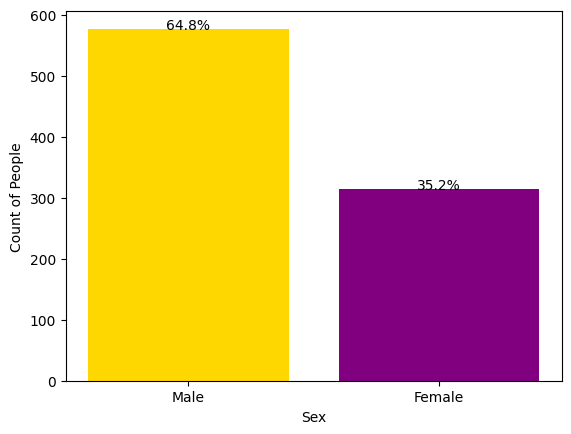

In [ ]:
# @title Understanding the difference of total population between the genders
male_count = df[df['Sex'] == 1].shape[0]
female_count = df[df['Sex'] == 2].shape[0]
total = len(df)
male_perc = round(100 * male_count / total, 1)
female_perc = round(100 * female_count / total, 1)

#Plotting bar chart
ax = sns.countplot(x="Sex", data=df)
plt.ylabel('Count of People')

ax.bar(0, male_count, color='gold')
ax.bar(1, female_count, color='purple')
ax.text(0, male_count, f"{male_perc}%", ha='center')
ax.text(1, female_count, f"{female_perc}%", ha='center')
ax.set_xticklabels(['Male', 'Female'])

Text(0.5, 1.0, 'Passenger Class: Who Survived?')

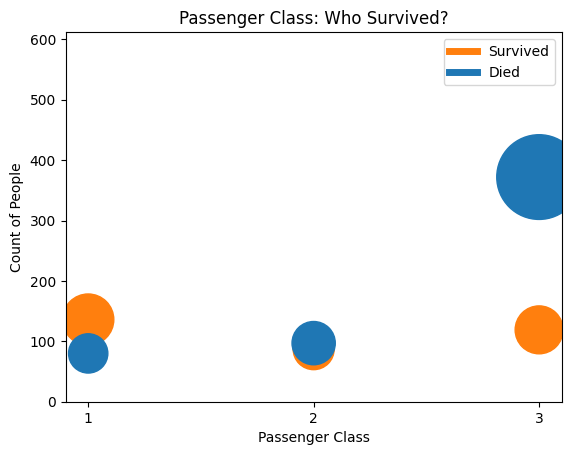

In [ ]:
# @title Understanding How Passanger Classes Compare in Deaths

#Grouping the counts by survived and passanger class
counts = df.groupby(['Pclass', 'Survived'])['PassengerId'].count().reset_index(name='Count')
survived_counts = counts[counts['Survived'] == 1]
died_counts = counts[counts['Survived'] == 0]

plt.scatter(survived_counts['Pclass'], survived_counts['Count'],
            s=survived_counts['Count']*10,
            color='tab:orange', label='Survived')
plt.scatter(died_counts['Pclass'], died_counts['Count'],
           s=died_counts['Count']*10,
           color='tab:blue', label='Died')

#Plotting bubble chart to understand size of those who survived according to the grouping
plt.ylim(0, max(survived_counts['Count'])*4.5)
plt.xticks(survived_counts['Pclass'].unique())
survived_line = plt.Line2D([0], [0], color='tab:orange', lw=5, label='Survived')
died_line = plt.Line2D([0], [0], color='tab:blue', lw=5, label='Died')
plt.legend(handles=[survived_line, died_line])
plt.xlabel('Passenger Class')
plt.ylabel('Count of People')
plt.title('Passenger Class: Who Survived?')

Text(0.5, 1.0, 'Children: 54.0% survived, 46.0% died\nAdults: 36.1% survived, 63.9% died')

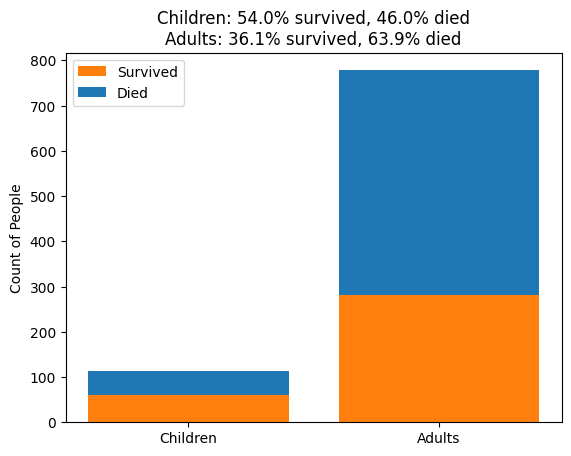

In [ ]:
# @title Understanding How Engineered Feature #1 Compares (Child vs. Adult Survival Comparison)

#Counting in another way different than the way above how child and adults survived/did not survive and creating percentages of how each group compares to each
isChild_count = df[df['IsChild'] == True].shape[0]
isNotChild_count = df[df['IsChild'] == False].shape[0]
child_survived = df[(df['IsChild'] == True) & (df['Survived'] == 1)].shape[0]
child_died = isChild_count - child_survived
child_survived_perc = child_survived / isChild_count * 100
child_died_perc = child_died / isChild_count * 100
adult_survived = df[(df['IsChild'] == False) & (df['Survived'] == 1)].shape[0]
adult_died = isNotChild_count - adult_survived
adult_survived_perc = adult_survived / isNotChild_count * 100
adult_died_perc = adult_died / isNotChild_count * 100

#Plotting bar chart to understand count size in comparison
plt.bar([0,1], [child_survived, adult_survived], label='Survived', color='tab:orange')
plt.bar([0,1], [child_died, adult_died], bottom=[child_survived, adult_survived], label='Died',color='tab:blue')
x = [0, 1]
ticks = ['Children', 'Adults']
plt.xticks(x, ticks)
plt.ylabel('Count of People')
plt.legend(labels=["Survived", "Died"])
plt.title(f"Children: {child_survived_perc:.1f}% survived, {child_died_perc:.1f}% died\nAdults: {adult_survived_perc:.1f}% survived, {adult_died_perc:.1f}% died")

Text(0.5, 1.0, 'Survived :33.8% of Low out of total Low,\n 79.4% of Medium out of total Medium,\n and 69.0% High out of total High')

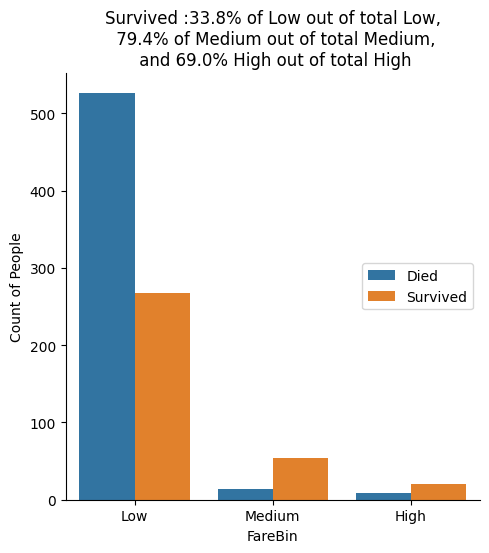

In [ ]:
# @title Understanding How Engineered Feature #2 Compares (Fare Survival Comparison)

#Counting in a similar way how fare bins survived or not
low_survived = df[(df['FareBin']=='Low') & (df['Survived']==1)].shape[0]
low_total = df[df['FareBin']=='Low'].shape[0]
low_perc = low_survived / low_total * 100
med_survived = df[(df['FareBin']=='Medium') & (df['Survived']==1)].shape[0]
med_total = df[df['FareBin']=='Medium'].shape[0]
med_perc = med_survived / med_total * 100
high_survived = df[(df['FareBin']=='High') & (df['Survived']==1)].shape[0]
high_total = df[df['FareBin']=='High'].shape[0]
high_perc = high_survived / high_total * 100

#Plotting catplot (to not do it the same way as above) to understand count size in comparison
colors = ["tab:blue", "tab:orange"]
FareBinGraph = sns.catplot(x='FareBin', hue='Survived', kind='count', data=df, palette=colors, legend_out = False)
plt.ylabel('Count of People')
plt.legend(labels=["Died", "Survived"], loc= 'center right')
title = f"Survived :{low_perc:.1f}% of Low out of total Low,\n {med_perc:.1f}% of Medium out of total Medium,\n and {high_perc:.1f}% High out of total High"
FareBinGraph.ax.set_title(title, horizontalalignment='center')


# Summary and Conclusions

#### Overall the story for this disaster is consistent. Examining the original features, one could see that the middle-aged adults made up a great percent of the population distribution, and consequently, it would be logical they would also not survive at the same rate. However, to confirm that children were prioritized at the time of evacuation, I enginereed a feature, and it was clear that children substantially survived at higher rates than the adults. Furthermore, passanger class survival rate shows that those with less premium fares died at more substantial rates. To confirm this, the second engineered feature confirmed the great survival disparity between those who had low fare tickets; they suffered the most casualties.

#### To conclude, it is important to note that when building a logistic regression model, having any of the characterstics mentioned before (being a middle-aged adult with a low fare ticket) would make you less prone to survive. Despite not diving into sex, this could also be a factor, but given the large amount of men in the boat, I would conclude that the factor is not as telling a the other two I mentioned. For purposes of this study, family size/siblings aboard was also not taken into account, but could merit its own study.